In [112]:
import sklearn
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [10]:
from sklearn.metrics import confusion_matrix

def get_metrics(y_true, y_pred, labels=None):
    """ Compute various measures from a confusion matrix

    Args:
        y_true: a column of the true labels.
        y_pred: a column of the predicted labels.
    Returns:
        A dictionary of metrics.
    """
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    tn, fp, fn, tp = conf_mat.ravel()

    return {'accuracy'          :  (tp + tn)/(tp + tn + fp + fn),
            'balanced_accuracy' :  0.5*tn / (tn+fp) + 0.5*tp / (tp+fn),
            'specificity'       :  tn / (tn+fp),
            'sensitivity'       :  tp / (tp+fn),
             'ppv'              :  tp / (tp + fp),
             'npv'              :  tn / (tn + fn)}

In [11]:
#!dir

# Classification Problem
Y = gold_glove

X = lgID, POS

In [13]:
gold_glove = pl.read_csv('./data/gold_glove.csv')
gold_glove.head()

playerID,yearID,lgID,POS,awardID,gold_glove,Training_Validation
str,i64,str,str,str,str,str
"""aardsda01""",2013,"""NL""","""P""",null,"""NO""","""Training"""
"""aardsda01""",2015,"""NL""","""P""",null,"""NO""","""Training"""
"""abadfe01""",2013,"""NL""","""P""",null,"""NO""","""Training"""
"""abadfe01""",2014,"""AL""","""P""",null,"""NO""","""Training"""
"""abadfe01""",2015,"""AL""","""P""",null,"""NO""","""Training"""


In [68]:
gold_glove['gold_glove'].unique().to_list()

['NO', 'Yes']

In [14]:
# Categorical values need to be encoded as numeric
gold_glove['POS'].unique().to_list()

['3B', 'C', '1B', 'OF', 'SS', 'P', '2B']

In [15]:
gold_glove['lgID'].unique().to_list()

['AL', 'NL']

In [16]:
gold_glove = (gold_glove
             .with_columns(lgID_numeric = pl.when(pl.col('lgID') == 'NL')
                                            .then(0)
                                            .when(pl.col('lgID') == 'AL')
                                            .then(1),
                           POS_numeric = pl.when(pl.col('POS') == 'P')
                                           .then(0)
                                           .when(pl.col('POS') == 'C')
                                           .then(1)
                                           .when(pl.col('POS') == '1B')
                                           .then(2)
                                           .when(pl.col('POS') == '2B')
                                           .then(3)
                                           .when(pl.col('POS') == '3B')
                                           .then(4)
                                           .when(pl.col('POS') == 'SS')
                                           .then(5)
                                           .when(pl.col('POS') == 'OF')
                                           .then(6)
                          )
             )
gold_glove.head()

playerID,yearID,lgID,POS,awardID,gold_glove,Training_Validation,lgID_numeric,POS_numeric
str,i64,str,str,str,str,str,i32,i32
"""aardsda01""",2013,"""NL""","""P""",null,"""NO""","""Training""",0,0
"""aardsda01""",2015,"""NL""","""P""",null,"""NO""","""Training""",0,0
"""abadfe01""",2013,"""NL""","""P""",null,"""NO""","""Training""",0,0
"""abadfe01""",2014,"""AL""","""P""",null,"""NO""","""Training""",1,0
"""abadfe01""",2015,"""AL""","""P""",null,"""NO""","""Training""",1,0


In [17]:
X_train_gold_glove = (gold_glove
                      .filter(pl.col('Training_Validation') == 'Training')
                      .drop(['playerID',
                             'gold_glove',
                             'awardID',
                             'Training_Validation',
                             'POS',
                             'lgID'
                            ])
                      )
X_train_gold_glove = X_train_gold_glove.to_pandas()
X_train_gold_glove.head()

,yearID,lgID_numeric,POS_numeric
0,2013,0,0
1,2015,0,0
2,2013,0,0
3,2014,1,0
4,2015,1,0


In [23]:
Y_train_gold_glove = (gold_glove
                      .filter(pl.col('Training_Validation') == 'Training')
                      .select(pl.col('gold_glove'))
                      )
Y_train_gold_glove = Y_train_gold_glove.to_pandas()
Y_train_gold_glove.head()

,gold_glove
0,NO
1,NO
2,NO
3,NO
4,NO


## Decision Tree Classifier

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [19]:
# A grid of parameters
import numpy as np

dtc_param_grid = {'max_depth': [None, 1,2,3,4,5],
                  'min_samples_split' : [1, 5, 10],
                  'min_samples_leaf' : [1, 5, 10],
                  'class_weight':[None, "balanced"]
              }
dtc_param_grid

{'max_depth': [None, 1, 2, 3, 4, 5],
 'min_samples_split': [1, 5, 10],
 'min_samples_leaf': [1, 5, 10],
 'class_weight': [None, 'balanced']}

In [20]:
# A fixed cross validation object
from sklearn.model_selection import StratifiedKFold

state = 458

cv_obj_dtc = StratifiedKFold(n_splits=10, shuffle=True, random_state=state)
cv_obj_dtc

StratifiedKFold(n_splits=10, random_state=458, shuffle=True)

In [21]:
# A grid search object combining all the previous parts.
dtc_grid_search = GridSearchCV(DecisionTreeClassifier(), dtc_param_grid, verbose=3, cv=cv_obj_dtc)

In [24]:
# Performing the grid search
dtc_grid_search.fit(X_train_gold_glove, Y_train_gold_glove)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, scor

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=458, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1, 5, 10]},
             verbose=3)

In [25]:
dtc_grid_search.best_score_

np.float64(0.993331723661434)

In [26]:
dtc_grid_search.best_params_

{'class_weight': None,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [165]:
best_model = dtc_grid_search.best_estimator_

best_model

DecisionTreeClassifier(min_samples_split=5)

In [28]:
gold_glove['Training_Validation'].unique().to_list()

['Validation', 'Training']

In [29]:
X_test_gold_glove = (gold_glove
                      .filter(pl.col('Training_Validation') == 'Validation')
                      .drop(['playerID',
                             'gold_glove',
                             'awardID',
                             'Training_Validation',
                             'POS',
                             'lgID'
                            ])
                      )
X_test_gold_glove = X_test_gold_glove.to_pandas()
X_test_gold_glove.head()

,yearID,lgID_numeric,POS_numeric
0,2023,0,0
1,2023,0,0
2,2023,0,0
3,2023,0,5
4,2023,1,0


In [30]:
Y_test_gold_glove = (gold_glove
                      .filter(pl.col('Training_Validation') == 'Validation')
                      .select(pl.col('gold_glove'))
                      )
Y_test_gold_glove = Y_test_gold_glove.to_pandas()
Y_test_gold_glove.head()

,gold_glove
0,NO
1,NO
2,NO
3,NO
4,NO


In [31]:
# Fit the model to the training data
dtc_y_test_pred = dtc_grid_search.predict(X_test_gold_glove)

dtc_y_test_pred

array(['NO', 'NO', 'NO', ..., 'NO', 'NO', 'NO'], dtype=object)

In [32]:
get_metrics(Y_test_gold_glove, dtc_y_test_pred)

C:\Users\mp5667di\AppData\Local\Temp\ipykernel_22140\1876480297.py:19: RuntimeWarning: invalid value encountered in scalar divide
  'ppv'              :  tp / (tp + fp),


{'accuracy': np.float64(0.9915966386554622),
 'balanced_accuracy': np.float64(0.5),
 'specificity': np.float64(1.0),
 'sensitivity': np.float64(0.0),
 'ppv': np.float64(nan),
 'npv': np.float64(0.9915966386554622)}

## Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
#?RandomForestClassifier

### RFC - Model 1

In [34]:
rfc_param_grid = {'n_estimators': 10 ** np.arange(1, 3),
                  'max_depth': [None, 1,2,3,4,5],
                  'min_samples_split' : [1, 5, 10],
                  'min_samples_leaf' : [1, 5, 10],
                  'class_weight':[None, "balanced"]
                 }
rfc_param_grid

{'n_estimators': array([ 10, 100]),
 'max_depth': [None, 1, 2, 3, 4, 5],
 'min_samples_split': [1, 5, 10],
 'min_samples_leaf': [1, 5, 10],
 'class_weight': [None, 'balanced']}

In [35]:
# A fixed cross validation object
from sklearn.model_selection import StratifiedKFold

state = 458

cv_obj_rfc = StratifiedKFold(n_splits=10, shuffle=True, random_state=state)
cv_obj_rfc

StratifiedKFold(n_splits=10, random_state=458, shuffle=True)

In [36]:
rfc_grid_search = GridSearchCV(RandomForestClassifier(), rfc_param_grid, verbose=3, cv=cv_obj_rfc)

rfc_grid_search.fit(X_train_gold_glove, Y_train_gold_glove)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=Non

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_sam

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_s

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_sample

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_s

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_sample

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_s

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_sample

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_samples

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_s

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_sample

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.5s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_samples

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_s

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END 

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.846 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.800 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.816 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.775 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.799 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.783 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.823 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.871 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.823 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.866 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.881 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.871 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.865 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.864 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.851 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.871 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.884 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.898 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.858 total time=   0.5s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.820 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.849 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.834 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.811 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.805 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.811 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.785 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.804 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.772 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.817 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.879 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.880 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.887 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.883 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.876 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.879 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.909 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.883 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.866 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.869 total time=   0.4s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.861 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.859 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.788 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.811 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.814 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.807 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.778 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.804 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.799 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.873 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.892 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.881 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.892 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.846 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.869 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.880 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.868 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.874 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.862 total time=   0.5s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.863 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.848 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.849 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.809 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.831 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.845 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.800 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.819 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.817 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.836 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.852 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.893 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.865 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.863 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.879 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.871 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.889 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.867 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.886 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.872 total time=   0.4s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[C

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.779 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.804 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.811 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.828 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.832 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.839 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.827 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.806 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.852 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.894 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.897 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.889 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.865 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.876 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.871 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.865 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.905 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.860 total time=   0.5s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.825 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.822 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.833 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.836 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.829 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.809 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.813 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.806 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.843 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.818 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.878 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.871 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.906 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.859 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.869 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.888 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.841 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.874 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.918 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.841 total time=   0.4s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weigh

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.421 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.433 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.434 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.649 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.430 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.433 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.437 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.441 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.417 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.421 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.414 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.434 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.436 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.430 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.437 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.441 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.625 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.421 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.433 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.436 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.430 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.433 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.499 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.441 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.417 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.421 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.414 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.436 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.430 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.437 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.421 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.433 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.488 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.436 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.430 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.459 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.437 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.441 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.417 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.440 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.414 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.434 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.436 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.430 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.437 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.441 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.646 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.691 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.414 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.518 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.583 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.430 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.433 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.437 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.441 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.424 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.421 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.414 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.436 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.430 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.437 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.421 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.433 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.586 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.493 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.496 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.557 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.441 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.417 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.421 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.414 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.434 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.436 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.430 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.437 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.441 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.417 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.421 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.865 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.586 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.430 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.614 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.437 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.441 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.417 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.421 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.414 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.436 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.430 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.437 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.568 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.433 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.450 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.543 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.513 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.598 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.514 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.482 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.451 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.462 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.420 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.440 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.533 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.449 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.444 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.566 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.417 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.429 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.433 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.469 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.520 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.580 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.447 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.524 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.453 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.480 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.414 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.482 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.473 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.437 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.449 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.532 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.488 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.436 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.430 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.530 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.437 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.459 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.417 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.499 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.414 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.440 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.482 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.482 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.444 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.441 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.476 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.421 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.499 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.623 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.480 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.473 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.454 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.469 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.437 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.494 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.477 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.458 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.414 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.475 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.483 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.452 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.444 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.503 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.433 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.433 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.557 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.571 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.565 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.560 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.585 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.465 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.459 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.458 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.414 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.434 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.482 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.439 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.452 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.437 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.441 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.417 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.593 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.467 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.449 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.462 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.452 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.494 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.441 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.462 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.517 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.414 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.453 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.475 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.485 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.437 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.569 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.499 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.454 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.552 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.563 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.545 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.540 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.600 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.586 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.557 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.575 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.563 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.581 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.593 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.593 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.643 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.596 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.607 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.555 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.547 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.593 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.563 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.556 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.574 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.518 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.580 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.578 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.579 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.582 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.575 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.578 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.589 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.568 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.547 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.511 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.599 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.491 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.595 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.541 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.562 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.573 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.555 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.560 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.590 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.570 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.583 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.583 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.599 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.580 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.545 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.536 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.569 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.550 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.555 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.604 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.531 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.600 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.593 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.580 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.578 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.560 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.570 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.583 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.585 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.537 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.543 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.476 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.579 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.598 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.558 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.586 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.556 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.575 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.565 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.586 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.573 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.578 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.582 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.594 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.600 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.590 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.575 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.553 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.582 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.568 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.612 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.548 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.591 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.604 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.535 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.544 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.586 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.562 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.587 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.560 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.570 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.583 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.593 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.570 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.624 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.606 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.575 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.598 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.627 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.583 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.658 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.601 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.578 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.569 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.580 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.597 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.595 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.599 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.613 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.584 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.604 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.580 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.601 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.584 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.584 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.583 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.602 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.613 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.592 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.578 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.612 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.601 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.580 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.585 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.593 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.594 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.613 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.596 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.604 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.617 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.572 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.599 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.610 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.596 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.613 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.593 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.598 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.601 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.580 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.583 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.582 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.586 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.596 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.590 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.604 total time=   0.4s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.621 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.599 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.595 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.568 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.598 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.595 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.583 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.622 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.598 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.584 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.593 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.580 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.590 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.595 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.599 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.604 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.596 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.578 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.563 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.576 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.590 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.621 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.630 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.619 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.585 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.591 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.581 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.580 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.592 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.3s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.595 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.594 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.604 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.584 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.594 total time=   0.4s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.584 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.580 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.593 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.580 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.611 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.604 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.627 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.601 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.642 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.588 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.601 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.580 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.586 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.595 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.591 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.608 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.586 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.604 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.606 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.578 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.599 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.574 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.628 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.621 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.618 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.620 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.579 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.589 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.599 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.572 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.588 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.572 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.596 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.596 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.576 total time=   0.4s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.608 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.605 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.610 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.572 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.604 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.599 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.609 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.613 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.616 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.578 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.564 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.575 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.608 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.565 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.588 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.572 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.599 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.613 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.585 total time=   0.4s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.606 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.622 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.565 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.616 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.599 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.621 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.654 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.602 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.603 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.576 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.606 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.610 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.565 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.572 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.613 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.589 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.600 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.586 total time=   0.4s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.631 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.603 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.600 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.598 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.623 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.583 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.624 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.608 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.609 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.600 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.564 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.587 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.609 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.560 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.588 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.572 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.601 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.586 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.603 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.583 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.643 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.615 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.576 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.606 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.632 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.600 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.640 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.606 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.609 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.567 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.588 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.612 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.572 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.613 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.587 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.594 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.595 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.594 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.654 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.613 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.564 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.591 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.590 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.591 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.632 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.604 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.619 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.588 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.586 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.591 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.573 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.572 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.608 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.633 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.611 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.588 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=458, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1, 5, 10],
                         'n_estimators': array([ 10, 100])},
             verbose=3)

In [48]:
rfc_grid_search.best_score_

np.float64(0.993331723661434)

In [49]:
rfc_grid_search.best_params_

{'class_weight': None,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': np.int64(10)}

In [50]:
rfc_grid_search.best_estimator_

RandomForestClassifier(min_samples_split=5, n_estimators=np.int64(10))

### RFC - Model 2

In [75]:
rfc_param_grid_2 = {'n_estimators': 10 ** np.arange(1, 3),
                  'max_depth': [None, 1,2,3,4,5],
                  'min_samples_split' : [1, 5, 10],
                  'min_samples_leaf' : [1, 5, 10],
                  'class_weight':[None, "balanced", 'balanced_subsample'],
                  'criterion': ["gini", "entropy", "log_loss"],
                  'max_features': ["sqrt", "log2", None],
                  'oob_score': [True, False],
                  'n_jobs': ['fit','predict','decision_path','apply']
                 }
rfc_param_grid_2

{'n_estimators': array([ 10, 100]),
 'max_depth': [None, 1, 2, 3, 4, 5],
 'min_samples_split': [1, 5, 10],
 'min_samples_leaf': [1, 5, 10],
 'class_weight': [None, 'balanced', 'balanced_subsample'],
 'criterion': ['gini', 'entropy', 'log_loss'],
 'max_features': ['sqrt', 'log2', None],
 'oob_score': [True, False],
 'n_jobs': ['fit', 'predict', 'decision_path', 'apply']}

In [76]:
rfc_grid_search_2 = GridSearchCV(RandomForestClassifier(), rfc_param_grid, verbose=3, cv=cv_obj_rfc)

rfc_grid_search_2.fit(X_train_gold_glove, Y_train_gold_glove)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=Non

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_sam

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s
[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s
[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_s

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s
[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s
[CV 5/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_sample

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_s

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s
[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.1s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_sample

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_s

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_sample

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_samples

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_s

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_sample

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_samples

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_s

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.993 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.994 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.993 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=None, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.994 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END 

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.822 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.800 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.792 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.788 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.807 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.857 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.823 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.881 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.883 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.870 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.875 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.852 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.859 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.862 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.883 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.870 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.869 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.800 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.847 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.847 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.794 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.773 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.789 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.817 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.811 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.816 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.799 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.868 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.870 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.879 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.885 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.843 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.874 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.856 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.903 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.904 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.892 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.837 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.803 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.781 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.793 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.819 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.781 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.831 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.824 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.859 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.874 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.828 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.852 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.873 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.889 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.889 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.886 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.907 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.864 total time=   0.4s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.822 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.847 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.810 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.811 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.831 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.829 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.807 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.807 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.835 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.800 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.876 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.904 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.896 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.871 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.840 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.871 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.877 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.894 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.865 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.866 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[C

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.819 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.872 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.800 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.839 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.817 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.818 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.825 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.810 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.858 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.873 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.885 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.871 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.846 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.870 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.863 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.901 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.863 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.878 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.815 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.830 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.800 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.838 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.849 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.828 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.818 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.830 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.801 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.825 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.858 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.868 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.905 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.845 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.856 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.874 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.881 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.882 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.889 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.860 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weigh

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.630 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.614 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.436 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.430 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.482 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.589 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.441 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.417 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.421 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.414 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.434 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.436 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.430 total time=   0.1s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.443 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.437 total time=   0.1s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.441 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.417 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.566 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.433 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.436 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.430 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.610 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.437 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.441 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.417 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.421 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.414 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.436 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.430 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.437 total time=   0.1s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.482 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.509 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.436 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.601 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.545 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.879 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.441 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.417 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.421 total time=   0.1s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.414 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.434 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.436 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.430 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.437 total time=   0.1s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.441 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.451 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.421 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.414 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.433 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.436 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.430 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.433 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.437 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.441 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.417 total time=   0.1s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.421 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.414 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.436 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.430 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.437 total time=   0.1s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.433 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.436 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.549 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.433 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.437 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.441 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.417 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.421 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.414 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.434 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.436 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.430 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.437 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.441 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.417 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.449 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.414 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.433 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.487 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.436 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.430 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.433 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.437 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.441 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.417 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.421 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.414 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.2s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.444 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.430 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.437 total time=   0.1s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.571 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.433 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.632 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.457 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.601 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.433 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.447 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.469 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.477 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.527 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.495 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.447 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.442 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.482 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.450 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.465 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.437 total time=   0.1s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.487 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.499 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.456 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.528 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.433 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.490 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.458 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.462 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.496 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.500 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.417 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.439 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.465 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.483 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.464 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.496 total time=   0.1s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.414 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.475 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.527 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.542 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.444 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.505 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.505 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.453 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.474 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.447 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.414 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.446 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.473 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.446 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.452 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.486 total time=   0.1s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.503 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.554 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.473 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.422 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.433 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.474 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.517 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.464 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.530 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.516 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.441 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.463 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.458 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.414 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.473 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.447 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.452 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.445 total time=   0.1s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.559 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.506 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.479 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.499 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.485 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.437 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.441 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.444 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.520 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.414 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.466 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.466 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.465 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.452 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.461 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.589 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.427 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.511 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.431 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.467 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.434 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.513 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.601 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.492 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.528 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.482 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.417 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.527 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.433 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.464 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.434 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.475 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.493 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.439 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.486 total time=   0.1s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.504 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.536 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.598 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.566 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.607 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.643 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.600 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.574 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.580 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.578 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.581 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.593 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.593 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.575 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.593 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.580 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.530 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.581 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.545 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.606 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.512 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.604 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.612 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.585 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.587 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.580 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.582 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.570 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.591 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.601 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.555 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.526 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.579 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.597 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.554 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.557 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.527 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.571 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.550 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.581 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.580 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.571 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.560 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.570 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.589 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.589 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.583 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.569 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.592 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.511 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.595 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.543 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.498 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.527 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.583 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.601 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.596 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.512 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.581 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.573 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.578 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.582 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.596 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.567 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.568 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.608 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.514 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.603 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.597 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.598 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.633 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.575 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.573 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.578 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.582 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.594 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.593 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.512 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.576 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.574 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.551 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.586 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.531 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.608 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.602 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.498 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.549 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.542 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.604 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.599 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.564 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.566 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.538 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.592 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.577 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.563 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.578 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.573 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.602 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.601 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.615 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.599 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.598 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.590 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.599 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.584 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.585 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.593 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.596 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.603 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.594 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.579 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.586 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.583 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.571 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.598 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.590 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.591 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.636 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.618 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.611 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.599 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.580 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.590 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.593 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.607 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.609 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.584 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.594 total time=   0.3s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.568 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.588 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.604 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.594 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.582 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.615 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.607 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.601 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.580 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.578 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.595 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.596 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.604 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.603 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.594 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.582 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.601 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.582 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.583 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.672 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.625 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.583 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.635 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.578 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.610 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.589 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.580 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.590 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.593 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.599 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.609 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.586 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.589 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.568 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.588 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.581 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.644 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.621 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.639 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.569 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.599 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.580 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.600 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.582 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.599 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.604 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.584 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.579 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.600 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.610 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.591 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.568 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.598 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.556 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.608 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.635 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.619 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.599 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.580 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.589 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.593 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.603 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.605 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.596 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.578 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.611 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.569 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.618 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.584 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.625 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.581 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.630 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.613 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.576 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.590 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.596 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.573 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.572 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.612 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.581 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.604 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.594 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.653 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.603 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.627 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.577 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.663 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.593 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.618 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.605 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.625 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.595 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.585 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.586 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.601 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.576 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.601 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.612 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.585 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.575 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.594 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.612 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.598 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.633 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.612 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.604 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.588 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.614 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.572 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.588 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.572 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.606 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.609 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.583 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.600 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.626 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.611 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.594 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.585 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.587 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.628 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.696 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.601 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.591 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.588 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.600 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.572 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.614 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.600 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.600 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.578 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.598 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.594 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.598 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.616 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.624 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.617 total time=   0.0s
[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.603 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.588 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.577 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.596 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.573 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.572 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.601 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.604 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.607 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.588 total time=   0.2s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.614 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.603 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.628 total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.588 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.622 total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.638 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.600 total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.599 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.620 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.610 total time=   0.0s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.588 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.580 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.599 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.568 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.598 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.572 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.610 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.631 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.600 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.583 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=458, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1, 5, 10],
                         'n_estimators': array([ 10, 100])},
             verbose=3)

In [81]:
rfc_grid_search_2.best_score_

np.float64(0.993331723661434)

In [82]:
rfc_grid_search_2.best_params_

{'class_weight': None,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': np.int64(10)}

In [166]:
rfc_grid_search_2.best_estimator_

RandomForestClassifier(min_samples_split=5, n_estimators=np.int64(10))

## Classification Problem Output

In [55]:
def get_class_prob_df(clf, X):
    """ Return a dataframe of class probabilities.

    Arg:
        clf:  A fitted model object
        X:    The matrix of (test) features.
    Returns: A dataframe of class probabilities
    """
    return pd.DataFrame(clf.predict_proba(X), columns=clf.classes_)

In [70]:
from sklearn.metrics import roc_auc_score

## Model 1: Decision Tree

In [52]:
dtc_grid_search.best_estimator_

DecisionTreeClassifier(min_samples_split=5)

In [56]:
dtc = DecisionTreeClassifier(min_samples_split=5)
dtc.fit(X_train_gold_glove, Y_train_gold_glove)

dtc_y_test_pred = dtc.predict(X_test_gold_glove)
dtc_y_test_prob = get_class_prob_df(dtc, X_test_gold_glove)

## Model 2: Random Forest Classifier

#### Grid search 1 and 2 shows the same accuracy score and the parameters.
#### This indicates that my Random Forest Classifier won't be any better with additional parameters. 

In [84]:
rfc_grid_search.best_score_

np.float64(0.993331723661434)

In [85]:
rfc_grid_search_2.best_score_

np.float64(0.993331723661434)

In [53]:
rfc_grid_search.best_estimator_

RandomForestClassifier(min_samples_split=5, n_estimators=np.int64(10))

In [86]:
rfc_grid_search_2.best_estimator_

RandomForestClassifier(min_samples_split=5, n_estimators=np.int64(10))

In [66]:
rfc = DecisionTreeClassifier(min_samples_split=5)
rfc.fit(X_train_gold_glove, Y_train_gold_glove)

rfc_y_test_pred = rfc.predict(X_test_gold_glove)
rfc_y_test_prob = get_class_prob_df(rfc, X_test_gold_glove)

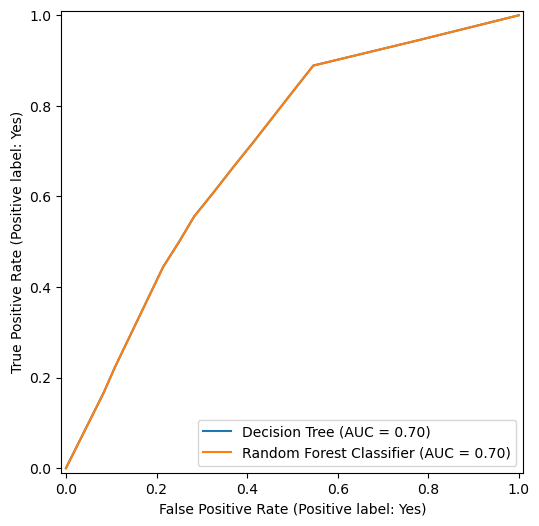

In [65]:
from sklearn.metrics import RocCurveDisplay

plt.rcParams["figure.figsize"] = (8,6)

# Make a blank plot/axis
ax = plt.gca()

# Plot each ROC curve by passing in the axis object to ax = ...
RocCurveDisplay.from_estimator(dtc, X_test_gold_glove, Y_test_gold_glove, ax = ax, name = "Decision Tree")
RocCurveDisplay.from_estimator(rfc, X_test_gold_glove, Y_test_gold_glove, ax = ax, name = "Random Forest Classifier")

plt.show()

## Comparing AUC Scores

In [71]:
roc_auc_score(Y_test_gold_glove, dtc_y_test_prob['Yes'])

np.float64(0.6997672107135383)

In [72]:
roc_auc_score(Y_test_gold_glove, rfc_y_test_prob['Yes'])

np.float64(0.6997672107135383)

<font color="orange">
    My conclusion here
</font>
   
    Based on the AUC scores, there is no difference between the 3 modesl that I created above. Decision Tree classifier works as great as the Random Forest Classifier in this problem (AUC scores indicate that the larger the value, the better the classifier).  

# Regression Problem

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [88]:
salaries = pl.read_csv('./data/salaries_df.csv')
salaries.head()

playerID,yearID,salary,stint,G,G_batting,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,W,L,GS,CG,SHO,SV,IPouts,ER,HR_right,BAOpp,ERA,WP,BK,BFP,GF,Training_Validation
str,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,str
"""metcatr01""",2008,392000.0,1,23,0,56,11,13,2,0,6,14,0,0,3,12,0,1,0,1,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Training"""
"""garkory01""",2010,550000.0,1,15,0,33,0,3,0,0,0,3,0,0,3,4,1,0,2,0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Training"""
"""sanchga01""",2012,483000.0,3,105,0,299,30,65,16,0,7,30,1,0,25,56,2,1,0,1,13,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Training"""
"""hoffmtr01""",2007,7e6,1,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5,0,0,0,42,172,19,2,0.228,2.98,0,0,235,50,"""Training"""
"""mauerjo01""",2006,400000.0,1,140,0,521,86,181,36,4,13,84,8,3,79,54,21,1,0,7,24,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Training"""


In [89]:
X_train_salaries = (salaries
                   .filter(pl.col('Training_Validation') == 'Training')
                   .drop(['salary','Training_Validation', 'playerID'])
                   )
X_train_salaries = X_train_salaries.to_pandas()
X_train_salaries.head()

,yearID,stint,G,G_batting,AB,R,H,2B,3B,HR,...,SV,IPouts,ER,HR_right,BAOpp,ERA,WP,BK,BFP,GF
0,2008,1.0,23.0,0.0,56.0,11.0,13.0,2.0,0.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,1.0,15.0,0.0,33.0,0.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012,3.0,105.0,0.0,299.0,30.0,65.0,16.0,0.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007,1.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42.0,172.0,19.0,2.0,0.228,2.98,0.0,0.0,235.0,50.0
4,2006,1.0,140.0,0.0,521.0,86.0,181.0,36.0,4.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
Y_train_salaries = (salaries
                   .filter(pl.col('Training_Validation') == 'Training')
                   .select(['salary'])
                   )
Y_train_salaries = Y_train_salaries.to_pandas()
Y_train_salaries.head()

,salary
0,392000.0
1,550000.0
2,483000.0
3,7000000.0
4,400000.0


## Decision Tree Regressor

### DTR - Model 1

In [92]:
import numpy as np

dtr_param_grid = {'max_depth': [None, 1,2,3,4,5],
                 'min_samples_split' : [1, 5, 10],
                 'min_samples_leaf' : [1, 5, 10]
                }

dtr_param_grid

{'max_depth': [None, 1, 2, 3, 4, 5],
 'min_samples_split': [1, 5, 10],
 'min_samples_leaf': [1, 5, 10]}

In [96]:
#?DecisionTreeRegressor

In [97]:
from sklearn.model_selection import KFold

state = 88393

my_cv_dtr = KFold(n_splits = 10, shuffle=True, random_state=state)
my_cv_dtr

KFold(n_splits=10, random_state=88393, shuffle=True)

In [98]:
dtr_grid_search = GridSearchCV(DecisionTreeRegressor(), 
                              dtr_param_grid, 
                              verbose=3, 
                              cv=my_cv_dtr
                              )
dtr_grid_search

GridSearchCV(cv=KFold(n_splits=10, random_state=88393, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1, 5, 10]},
             verbose=3)

In [99]:
dtr_grid_search.fit(X_train_salaries, Y_train_salaries)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 9/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 10/10] END max_depth=Non

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py"

GridSearchCV(cv=KFold(n_splits=10, random_state=88393, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1, 5, 10]},
             verbose=3)

#### DTR - Model 2

In [113]:
dtr_param_grid_2 = {'max_depth': [None, 1,2,3,4,5],
                    'min_samples_split' : [1, 5, 10],
                    'splitter': ["best", "random"],
                    'max_features': [1, 5, 10, "sqrt", "log2"]
                }
dtr_param_grid_2

{'max_depth': [None, 1, 2, 3, 4, 5],
 'min_samples_split': [1, 5, 10],
 'splitter': ['best', 'random'],
 'max_features': [1, 5, 10, 'sqrt', 'log2']}

In [114]:
dtr_grid_search_2 = GridSearchCV(DecisionTreeRegressor(), 
                                 dtr_param_grid_2, 
                                 verbose=3, 
                                 cv=my_cv_dtr
                                )
dtr_grid_search_2

GridSearchCV(cv=KFold(n_splits=10, random_state=88393, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [1, 5, 10, 'sqrt', 'log2'],
                         'min_samples_split': [1, 5, 10],
                         'splitter': ['best', 'random']},
             verbose=3)

In [115]:
dtr_grid_search_2.fit(X_train_salaries, Y_train_salaries)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[CV 1/10] END max_depth=None, max_features=1, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 2/10] END max_depth=None, max_features=1, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 3/10] END max_depth=None, max_features=1, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 4/10] END max_depth=None, max_features=1, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 5/10] END max_depth=None, max_features=1, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 6/10] END max_depth=None, max_features=1, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 7/10] END max_depth=None, max_features=1, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 8/10] END max_depth=None, max_features=1, min_samples_split=1, splitter=best;, score=nan total time=   0.0s
[CV 9/10] END max_depth=None, max_featu

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1200 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.p

GridSearchCV(cv=KFold(n_splits=10, random_state=88393, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [1, 5, 10, 'sqrt', 'log2'],
                         'min_samples_split': [1, 5, 10],
                         'splitter': ['best', 'random']},
             verbose=3)

In [116]:
dtr_grid_search.best_score_

np.float64(0.2271199220629938)

In [117]:
dtr_grid_search_2.best_score_

np.float64(0.2068037331313791)

In [22]:
dtr_grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 5}

In [119]:
dtr_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=5)

In [118]:
dtr_grid_search_2.best_params_

{'max_depth': 5,
 'max_features': 10,
 'min_samples_split': 10,
 'splitter': 'best'}

In [120]:
dtr_grid_search_2.best_estimator_

DecisionTreeRegressor(max_depth=5, max_features=10, min_samples_split=10)

In [121]:
X_test_salaries = (salaries
                   .filter(pl.col('Training_Validation') == 'Validation')
                   .drop(['salary','Training_Validation', 'playerID'])
                   )
X_test_salaries = X_test_salaries.to_pandas()
X_test_salaries.head()

,yearID,stint,G,G_batting,AB,R,H,2B,3B,HR,...,SV,IPouts,ER,HR_right,BAOpp,ERA,WP,BK,BFP,GF
0,2016,1.0,109.0,0.0,304.0,38.0,67.0,21.0,1.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,1.0,158.0,0.0,597.0,89.0,166.0,36.0,3.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,1.0,119.0,0.0,217.0,19.0,41.0,10.0,0.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,1.0,119.0,0.0,217.0,19.0,41.0,10.0,0.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,1.0,130.0,0.0,471.0,72.0,135.0,22.0,1.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
Y_test_salaries = (salaries
                   .filter(pl.col('Training_Validation') == 'Validation')
                   .select(['salary'])
                   )
Y_test_salaries = Y_test_salaries.to_pandas()
Y_test_salaries.head()

,salary
0,517246.0
1,8000000.0
2,1000000.0
3,1000000.0
4,3150000.0


In [123]:
# Measuring the performance
dtr_y_test_pred = dtr_grid_search.predict(X_test_salaries)

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error


{
    'R^2': explained_variance_score(Y_test_salaries, dtr_y_test_pred),
    'MSE': mean_squared_error(Y_test_salaries, dtr_y_test_pred),
    'MAE': mean_absolute_error(Y_test_salaries, dtr_y_test_pred),
}

{'R^2': 0.21808086999555043,
 'MSE': np.float64(23573377589891.348),
 'MAE': np.float64(3163603.3400072413)}

## Random Forest Regressor

In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [125]:
import numpy as np

rfr_param_grid = {
              'n_estimators': [10, 50, 99],
              'max_depth': [None, 1,2,3,4,5],
              'min_samples_split' : [1, 5, 10],
              'min_samples_leaf' : [1, 5, 10],
              }

rfr_param_grid

{'n_estimators': [10, 50, 99],
 'max_depth': [None, 1, 2, 3, 4, 5],
 'min_samples_split': [1, 5, 10],
 'min_samples_leaf': [1, 5, 10]}

In [126]:
from sklearn.model_selection import KFold

state = 88393

my_cv_rfr = KFold(n_splits = 10, shuffle=True, random_state=state)
my_cv_rfr

KFold(n_splits=10, random_state=88393, shuffle=True)

In [127]:
rfr_grid_search = GridSearchCV(RandomForestRegressor(), 
                               rfr_param_grid, 
                               verbose=3, 
                               cv=my_cv_rfr
                               )

In [128]:
rfr_grid_search.fit(X_train_salaries, Y_train_salaries)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits
[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.334 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.267 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.317 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.283 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.320 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.308 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.335 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.324 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.383 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.308 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.368 total time=   3.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.315 total time=   3.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.350 total time=   3.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.334 total time=   3.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.411 total time=   3.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.344 total time=   3.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.392 total time=   3.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.345 total time=   3.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.440 total time=   3.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.386 total time=   3.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.371 total time=   7.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.328 total time=   7.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.370 total time=   7.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.341 total time=   7.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.411 total time=   7.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.353 total time=   7.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.392 total time=   7.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.354 total time=   7.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.439 total time=   7.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.400 total time=   7.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.342 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.298 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.334 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.308 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.326 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.314 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.321 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.312 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.394 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.349 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.364 total time=   3.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.296 total time=   3.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.357 total time=   3.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.329 total time=   3.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.407 total time=   3.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.344 total time=   3.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.372 total time=   3.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.332 total time=   3.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.431 total time=   3.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.368 total time=   3.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.375 total time=   6.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.308 total time=   6.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.353 total time=   6.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.345 total time=   6.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.407 total time=   6.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.353 total time=   6.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.385 total time=   6.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.341 total time=   6.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.424 total time=   6.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.383 total time=   6.5s
[CV 1/10] END max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=None, min_samples_leaf=5, mi

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.321 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.289 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.331 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.318 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.340 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.297 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.351 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.253 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.375 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.334 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.354 total time=   2.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.308 total time=   2.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.348 total time=   2.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.321 total time=   3.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.403 total time=   2.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.351 total time=   2.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.377 total time=   2.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.338 total time=   2.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.406 total time=   2.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.381 total time=   2.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.370 total time=   5.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.309 total time=   5.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.348 total time=   5.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.325 total time=   5.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.397 total time=   5.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.355 total time=   5.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.389 total time=   5.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.342 total time=   6.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.409 total time=   6.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.379 total time=   5.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.324 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.254 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.317 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.279 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.355 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.354 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.327 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.328 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.384 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.372 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.361 total time=   2.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.303 total time=   2.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.342 total time=   2.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.320 total time=   2.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.412 total time=   2.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.352 total time=   2.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.388 total time=   2.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.342 total time=   2.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.408 total time=   2.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.363 total time=   2.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.361 total time=   6.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.314 total time=   5.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.352 total time=   5.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.325 total time=   6.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.409 total time=   5.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.353 total time=   5.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.387 total time=   5.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.341 total time=   5.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.407 total time=   5.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.374 total time=   5.5s
[CV 1/10] END max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=None, min_samples_lea

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.321 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.249 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.307 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.292 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.349 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.300 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.353 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.314 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.375 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.351 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.340 total time=   2.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.291 total time=   2.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.345 total time=   2.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.293 total time=   2.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.383 total time=   2.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.334 total time=   2.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.346 total time=   2.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.317 total time=   2.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.386 total time=   2.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.361 total time=   2.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.360 total time=   4.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.294 total time=   4.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.333 total time=   4.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.304 total time=   4.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.382 total time=   4.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.331 total time=   4.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.368 total time=   4.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.309 total time=   4.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.389 total time=   4.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.359 total time=   5.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.301 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.265 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.329 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.284 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.354 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.316 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.332 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.296 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.376 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.338 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.355 total time=   2.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.299 total time=   2.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.332 total time=   2.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.301 total time=   2.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.375 total time=   2.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.327 total time=   2.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.348 total time=   3.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.309 total time=   2.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.394 total time=   2.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.358 total time=   2.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.348 total time=   5.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.300 total time=   5.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.350 total time=   5.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.305 total time=   5.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.386 total time=   4.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.329 total time=   5.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.359 total time=   5.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.313 total time=   4.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.384 total time=   5.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.354 total time=   4.7s
[CV 1/10] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=1, min_samples_leaf=1, min_samples_split=1, n_es

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 2/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.064 total time=   0.0s
[CV 3/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.115 total time=   0.0s
[CV 4/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.093 total time=   0.0s
[CV 5/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.110 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.098 total time=   0.0s
[CV 7/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.085 total time=   0.0s
[CV 8/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.075 total time=   0.0s
[CV 9/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.133 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.060 total time=   0.0s
[CV 1/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.077 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.067 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.113 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.094 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.113 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.102 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.079 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.083 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.136 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.066 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.079 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.070 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.115 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.092 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.113 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.104 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.083 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.083 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.135 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.068 total time=   0.4s
[CV 1/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.075 total time=   0.0s
[CV 2/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.065 total time=   0.0s
[CV 3/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.111 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.094 total time=   0.0s
[CV 5/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.108 total time=   0.0s
[CV 6/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.103 total time=   0.0s
[CV 7/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.077 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.085 total time=   0.0s
[CV 9/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.137 total time=   0.0s
[CV 10/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.065 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.075 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.064 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.114 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.093 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.113 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.101 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.080 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.082 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.137 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.065 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.076 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.066 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.113 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.092 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.113 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.103 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.083 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.083 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.136 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.066 total time=   0.4s
[CV 1/10] END max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estima

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.111 total time=   0.0s
[CV 4/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.092 total time=   0.0s
[CV 5/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.109 total time=   0.0s
[CV 6/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.101 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.085 total time=   0.0s
[CV 8/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.083 total time=   0.0s
[CV 9/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.137 total time=   0.0s
[CV 10/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.069 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.076 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.067 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.114 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.093 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.113 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.102 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.080 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.086 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.135 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.066 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.074 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.065 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.114 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.091 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.112 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.102 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.085 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.084 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.137 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.066 total time=   0.4s
[CV 1/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.081 total time=   0.0s
[CV 2/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.065 total time=   0.0s
[CV 3/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.111 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.091 total time=   0.0s
[CV 5/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.109 total time=   0.0s
[CV 6/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.095 total time=   0.0s
[CV 7/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.084 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.082 total time=   0.0s
[CV 9/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.136 total time=   0.0s
[CV 10/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.063 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.076 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.070 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.113 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.094 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.113 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.101 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.078 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.081 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.133 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.071 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.076 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.066 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.114 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.093 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.114 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.102 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.081 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.084 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.135 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.067 total time=   0.4s
[CV 1/10] END max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=1, min_samples_leaf=10, min_samples_split=1, 

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 3/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.113 total time=   0.0s
[CV 4/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.093 total time=   0.0s
[CV 5/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.114 total time=   0.0s
[CV 6/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.102 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 7/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.079 total time=   0.0s
[CV 8/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.082 total time=   0.0s
[CV 9/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.136 total time=   0.0s
[CV 10/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.065 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.072 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.067 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.114 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.092 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.111 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.101 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.083 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.083 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.137 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.069 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.075 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.065 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.114 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.094 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.113 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.102 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.082 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.084 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.135 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.064 total time=   0.4s
[CV 1/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.078 total time=   0.0s
[CV 2/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.069 total time=   0.0s
[CV 3/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.114 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 4/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.092 total time=   0.0s
[CV 5/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.111 total time=   0.0s
[CV 6/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.099 total time=   0.0s
[CV 7/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.086 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 8/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.081 total time=   0.0s
[CV 9/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.135 total time=   0.0s
[CV 10/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.063 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.080 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.064 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.115 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.094 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.113 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.103 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.081 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.080 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.136 total time=   0.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.071 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.076 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.066 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.113 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.093 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.114 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.103 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.084 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.084 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.135 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.064 total time=   0.4s
[CV 1/10] END max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estim

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.126 total time=   0.0s
[CV 3/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.207 total time=   0.0s
[CV 4/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.153 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.217 total time=   0.0s
[CV 6/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.201 total time=   0.0s
[CV 7/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.163 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.151 total time=   0.0s
[CV 9/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.212 total time=   0.0s
[CV 10/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.186 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.149 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.137 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.203 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.160 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.212 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.200 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.155 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.144 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.214 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.181 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.145 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.138 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.202 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.160 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.218 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.200 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.159 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.147 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.217 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.188 total time=   0.7s
[CV 1/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.153 total time=   0.0s
[CV 2/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.146 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.206 total time=   0.0s
[CV 4/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.159 total time=   0.0s
[CV 5/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.213 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.200 total time=   0.0s
[CV 7/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.153 total time=   0.0s
[CV 8/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.139 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.211 total time=   0.0s
[CV 10/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.191 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.139 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.144 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.202 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.161 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.217 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.201 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.156 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.149 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.212 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.184 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.145 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.140 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.204 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.161 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.217 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.202 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.158 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.150 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.216 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.182 total time=   0.7s
[CV 1/10] END max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estima

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.152 total time=   0.0s
[CV 3/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.214 total time=   0.0s
[CV 4/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.156 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.203 total time=   0.0s
[CV 6/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.197 total time=   0.0s
[CV 7/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.162 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.132 total time=   0.0s
[CV 9/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.218 total time=   0.0s
[CV 10/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.182 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.138 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.140 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.202 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.158 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.212 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.203 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.162 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.145 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.215 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.183 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.149 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.139 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.203 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.162 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.214 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.203 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.156 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.150 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.215 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.182 total time=   0.8s
[CV 1/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.145 total time=   0.0s
[CV 2/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.146 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.209 total time=   0.0s
[CV 4/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.160 total time=   0.0s
[CV 5/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.214 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.198 total time=   0.0s
[CV 7/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.160 total time=   0.0s
[CV 8/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.148 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.215 total time=   0.0s
[CV 10/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.172 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.131 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.137 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.203 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.159 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.219 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.199 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.166 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.148 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.222 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.188 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.139 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.136 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.203 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.162 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.217 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.201 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.156 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.146 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.219 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.187 total time=   0.8s
[CV 1/10] END max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=2, min_samples_leaf=10, min_samples_split=1, 

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.119 total time=   0.0s
[CV 3/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.202 total time=   0.0s
[CV 4/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.167 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.219 total time=   0.0s
[CV 6/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.196 total time=   0.0s
[CV 7/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.150 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.150 total time=   0.0s
[CV 9/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.219 total time=   0.0s
[CV 10/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.179 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.138 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.143 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.206 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.164 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.213 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.204 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.156 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.142 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.212 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.182 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.143 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.142 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.202 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.162 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.214 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.203 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.159 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.146 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.215 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.186 total time=   0.7s
[CV 1/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.147 total time=   0.0s
[CV 2/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.133 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.202 total time=   0.0s
[CV 4/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.159 total time=   0.0s
[CV 5/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.212 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.193 total time=   0.0s
[CV 7/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.159 total time=   0.0s
[CV 8/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.139 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.211 total time=   0.0s
[CV 10/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.182 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.146 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.140 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.200 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.158 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.214 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.197 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.159 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.147 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.217 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.187 total time=   0.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.144 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.137 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.202 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.162 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.217 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.201 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.159 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.147 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.216 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.187 total time=   0.7s
[CV 1/10] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estim

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.187 total time=   0.0s
[CV 2/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.165 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.236 total time=   0.0s
[CV 4/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.187 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.245 total time=   0.0s
[CV 6/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.200 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.175 total time=   0.0s
[CV 8/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.166 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.261 total time=   0.0s
[CV 10/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.210 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.197 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.169 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.239 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.189 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.253 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.217 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.182 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.182 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.254 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.224 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.194 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.168 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.237 total time=   1.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.193 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.252 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.211 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.191 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.179 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.254 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.224 total time=   1.2s
[CV 1/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.195 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.160 total time=   0.0s
[CV 3/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.229 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.186 total time=   0.0s
[CV 5/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.249 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.187 total time=   0.1s
[CV 7/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.193 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.179 total time=   0.0s
[CV 9/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.251 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.225 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.193 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.167 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.234 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.191 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.256 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.211 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.186 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.181 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.254 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.221 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.194 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.171 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.232 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.188 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.253 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.210 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.192 total time=   1.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.176 total time=   1.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.255 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.224 total time=   1.1s
[CV 1/10] END max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estima

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.181 total time=   0.0s
[CV 2/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.168 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.231 total time=   0.0s
[CV 4/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.187 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.256 total time=   0.0s
[CV 6/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.218 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.191 total time=   0.0s
[CV 8/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.170 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.248 total time=   0.0s
[CV 10/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.234 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.193 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.168 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.233 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.190 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.250 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.207 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.192 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.179 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.254 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.227 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.193 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.168 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.239 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.190 total time=   1.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.251 total time=   1.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.208 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.191 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.180 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.254 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.222 total time=   1.1s
[CV 1/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.198 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.158 total time=   0.0s
[CV 3/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.240 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.189 total time=   0.0s
[CV 5/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.244 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.190 total time=   0.0s
[CV 7/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.180 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.174 total time=   0.0s
[CV 9/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.253 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.229 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.192 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.167 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.234 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.189 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.248 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.211 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.185 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.181 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.251 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.227 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.194 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.168 total time=   1.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.236 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.191 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.250 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.207 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.189 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.176 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.249 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.223 total time=   1.1s
[CV 1/10] END max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=3, min_samples_leaf=10, min_samples_split=1, 

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.185 total time=   0.0s
[CV 2/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.165 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.235 total time=   0.0s
[CV 4/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.187 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.249 total time=   0.0s
[CV 6/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.202 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.181 total time=   0.0s
[CV 8/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.178 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.256 total time=   0.0s
[CV 10/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.226 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.194 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.168 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.242 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.188 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.250 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.209 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.189 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.178 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.253 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.227 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.199 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.164 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.237 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.190 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.247 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.208 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.193 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.181 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.253 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.225 total time=   1.1s
[CV 1/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.192 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.162 total time=   0.0s
[CV 3/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.235 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.175 total time=   0.0s
[CV 5/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.244 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.220 total time=   0.0s
[CV 7/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.191 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.171 total time=   0.0s
[CV 9/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.247 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.226 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.197 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.167 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.235 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.187 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.252 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.210 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.193 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.178 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.252 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.224 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.197 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.168 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.238 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.189 total time=   1.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.250 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.207 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.189 total time=   1.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.183 total time=   1.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.254 total time=   1.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.223 total time=   1.2s
[CV 1/10] END max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estim

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.219 total time=   0.1s
[CV 2/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.206 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.253 total time=   0.1s
[CV 4/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.217 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.274 total time=   0.1s
[CV 6/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.217 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.205 total time=   0.1s
[CV 8/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.207 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.291 total time=   0.1s
[CV 10/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.239 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.234 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.204 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.269 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.218 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.298 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.225 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.222 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.207 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.295 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.260 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.236 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.200 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.258 total time=   1.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.213 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.295 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.232 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.217 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.205 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.295 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.259 total time=   1.5s
[CV 1/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.220 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.196 total time=   0.1s
[CV 3/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.256 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.197 total time=   0.1s
[CV 5/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.288 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.230 total time=   0.1s
[CV 7/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.209 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.200 total time=   0.1s
[CV 9/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.295 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.263 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.225 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.200 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.260 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.211 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.297 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.226 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.213 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.205 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.292 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.259 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.229 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.206 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.257 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.214 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.293 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.231 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.215 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.209 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.298 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.260 total time=   1.4s
[CV 1/10] END max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estima

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.215 total time=   0.1s
[CV 2/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.193 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.245 total time=   0.1s
[CV 4/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.214 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.298 total time=   0.1s
[CV 6/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.212 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.217 total time=   0.1s
[CV 8/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.195 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.290 total time=   0.1s
[CV 10/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.260 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.237 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.205 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.258 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.221 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.299 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.229 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.215 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.203 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.297 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.259 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.238 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.202 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.255 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.213 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.297 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.229 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.222 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.211 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.295 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.259 total time=   1.4s
[CV 1/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.219 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.195 total time=   0.1s
[CV 3/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.248 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.200 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.286 total time=   0.1s
[CV 6/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.218 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.210 total time=   0.1s
[CV 8/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.207 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.284 total time=   0.1s
[CV 10/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.251 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.232 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.197 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.260 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.219 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.291 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.234 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.218 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.210 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.294 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.256 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.236 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.205 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.260 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.217 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.295 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.230 total time=   1.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.218 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.208 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.297 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.260 total time=   1.4s
[CV 1/10] END max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=4, min_samples_leaf=10, min_samples_split=1, 

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.237 total time=   0.1s
[CV 2/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.197 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.266 total time=   0.1s
[CV 4/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.222 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.293 total time=   0.1s
[CV 6/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.208 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.205 total time=   0.1s
[CV 8/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.205 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.291 total time=   0.1s
[CV 10/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.250 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.236 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.203 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.267 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.214 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.297 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.227 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.220 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.209 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.291 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.259 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.236 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.205 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.262 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.213 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.296 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.230 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.218 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.208 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.292 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.260 total time=   1.5s
[CV 1/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.231 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.198 total time=   0.1s
[CV 3/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.252 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.213 total time=   0.1s
[CV 5/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.297 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.226 total time=   0.1s
[CV 7/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.216 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.207 total time=   0.1s
[CV 9/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.296 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.260 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.235 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.203 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.261 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.218 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.297 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.232 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.219 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.212 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.292 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.267 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.237 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.203 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.260 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.216 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.295 total time=   1.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.231 total time=   1.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.218 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.210 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.291 total time=   1.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.261 total time=   1.4s
[CV 1/10] END max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estim

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.257 total time=   0.1s
[CV 2/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.224 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.278 total time=   0.1s
[CV 4/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.218 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.321 total time=   0.1s
[CV 6/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.228 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.237 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.213 total time=   0.1s
[CV 9/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.324 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.273 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.264 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.232 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.280 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.226 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.320 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.249 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.248 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.229 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.317 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.284 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.263 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.226 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.269 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.230 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.324 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.244 total time=   2.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.250 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.226 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.320 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=99;, score=0.288 total time=   1.8s
[CV 1/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.252 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.222 total time=   0.1s
[CV 3/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.258 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.216 total time=   0.1s
[CV 5/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.306 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.233 total time=   0.1s
[CV 7/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.251 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.210 total time=   0.1s
[CV 9/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.313 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=0.282 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.268 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.224 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.271 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.233 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.320 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.241 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.253 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.226 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.321 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.275 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.262 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.232 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.272 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.227 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.323 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.246 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.251 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.226 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.318 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=99;, score=0.284 total time=   1.8s
[CV 1/10] END max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estima

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.248 total time=   0.1s
[CV 2/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.221 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.274 total time=   0.1s
[CV 4/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.223 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.318 total time=   0.1s
[CV 6/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.246 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.236 total time=   0.1s
[CV 8/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.233 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.318 total time=   0.1s
[CV 10/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=0.290 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.259 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.229 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.276 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.223 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.322 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.249 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.255 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.230 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.324 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.279 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.265 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.226 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.269 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.228 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.325 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.247 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.254 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.229 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.320 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=99;, score=0.289 total time=   1.7s
[CV 1/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.251 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.222 total time=   0.1s
[CV 3/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.274 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.212 total time=   0.1s
[CV 5/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.322 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.238 total time=   0.1s
[CV 7/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.252 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.219 total time=   0.1s
[CV 9/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.317 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=0.290 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.269 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.229 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.269 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.225 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.317 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.245 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.254 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.228 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.324 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.285 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.267 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.228 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.271 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.230 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.316 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.246 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.250 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.226 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.320 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=99;, score=0.286 total time=   1.8s
[CV 1/10] END max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=10;, score=nan total time=   0.0s
[CV 8/10] END max_depth=5, min_samples_leaf=10, min_samples_split=1, 

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.271 total time=   0.1s
[CV 2/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.231 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.269 total time=   0.1s
[CV 4/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.218 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.303 total time=   0.1s
[CV 6/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.235 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.247 total time=   0.1s
[CV 8/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.228 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.312 total time=   0.1s
[CV 10/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=0.275 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.271 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.232 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.277 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.224 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.317 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.244 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.259 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.230 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.321 total time=   1.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.289 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.270 total time=   2.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.232 total time=   2.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.274 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.229 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.322 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.246 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.246 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.226 total time=   2.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.316 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=99;, score=0.290 total time=   1.8s
[CV 1/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.270 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.228 total time=   0.1s
[CV 3/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.281 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.224 total time=   0.1s
[CV 5/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.313 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.253 total time=   0.1s
[CV 7/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.249 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.214 total time=   0.1s
[CV 9/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.302 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.282 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.271 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.231 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.276 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.225 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.322 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.248 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.254 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.229 total time=   0.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.322 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.284 total time=   1.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.268 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.231 total time=   2.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.272 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.227 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.318 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.244 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.252 total time=   1.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.236 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.316 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=99;, score=0.287 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py

GridSearchCV(cv=KFold(n_splits=10, random_state=88393, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1, 5, 10],
                         'n_estimators': [10, 50, 99]},
             verbose=3)

In [136]:
rfr_grid_search.best_score_

np.float64(0.3759241839394481)

In [137]:
rfr_grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 99}

In [138]:
rfr_grid_search.best_estimator_

RandomForestRegressor(min_samples_split=5, n_estimators=99)

In [141]:
?RandomForestRegressor

Init signature:
RandomForestRegressor(
    n_estimators=100,
    *,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None,
)
Docstring:     
A random forest regressor.

A random forest is a meta estimator that fits a number of decision tree
regressors on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
Trees in the forest use the best split strategy, i.e. equivalent to passing
`splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is use

In [142]:
rfr_param_grid_2 = {
              'n_estimators': [10, 99],
              'max_depth': [None, 1, 5],
              'min_samples_split' : [1, 5],
              'monotonic_cst': [None, 1, 0, -1],
              'ccp_alpha': [0.0, 0.5, 0.8]
              }
rfr_param_grid_2

{'n_estimators': [10, 99],
 'max_depth': [None, 1, 5],
 'min_samples_split': [1, 5],
 'monotonic_cst': [None, 1, 0, -1],
 'ccp_alpha': [0.0, 0.5, 0.8]}

In [143]:
rfr_grid_search_2 = GridSearchCV(RandomForestRegressor(), 
                               rfr_param_grid_2, 
                               verbose=3, 
                               cv=my_cv_rfr
                               )

In [144]:
rfr_grid_search_2.fit(X_train_salaries, Y_train_salaries)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV 1/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=1, monotonic_cst=None, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=1, monotonic_cst=None, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=1, monotonic_cst=None, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=1, monotonic_cst=None, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=1, monotonic_cst=None, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=1, monotonic_cst=None, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=1, monotonic_cst=None, n_estimators=10;, score=nan total time=   0.0s
[CV 

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.327 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.257 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.351 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.296 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.373 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.304 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.337 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.345 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.384 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.344 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.382 total time=   7.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.317 total time=   8.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.365 total time=   7.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.344 total time=   7.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.419 total time=   7.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.368 total time=   7.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.383 total time=   7.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.354 total time=   7.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.450 total time=   7.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.388 total time=   7.8s
[CV 1/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END ccp_alpha=0.0, max_depth=None, min_samples_split=5, monotonic_cst=1, n

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 2/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.063 total time=   0.0s
[CV 3/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.110 total time=   0.0s
[CV 4/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.090 total time=   0.0s
[CV 5/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.112 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.102 total time=   0.0s
[CV 7/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.075 total time=   0.0s
[CV 8/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.081 total time=   0.0s
[CV 9/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.138 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.064 total time=   0.0s
[CV 1/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.076 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.065 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.114 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.092 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.113 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.102 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.085 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.080 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.137 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.066 total time=   0.4s
[CV 1/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END ccp_alpha=0.0, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=n

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.243 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.232 total time=   0.1s
[CV 3/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.255 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.216 total time=   0.1s
[CV 5/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.329 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.244 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.243 total time=   0.1s
[CV 8/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.211 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.304 total time=   0.1s
[CV 10/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.284 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.265 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.225 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.266 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.233 total time=   2.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.324 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.245 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.256 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.226 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.318 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.289 total time=   1.9s
[CV 1/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END ccp_alpha=0.0, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=n

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.314 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.246 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.322 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.250 total time=   0.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.358 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.307 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.330 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.273 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.402 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.335 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.383 total time=   7.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.320 total time=   8.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.362 total time=   8.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.333 total time=   8.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.408 total time=   7.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.364 total time=   8.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.389 total time=   7.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.353 total time=   7.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.436 total time=   7.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.384 total time=   7.6s
[CV 1/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END ccp_alpha=0.5, max_depth=None, min_samples_split=5, monotonic_cst=1, n

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 2/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.066 total time=   0.0s
[CV 3/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.111 total time=   0.0s
[CV 4/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.095 total time=   0.0s
[CV 5/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.106 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.104 total time=   0.0s
[CV 7/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.084 total time=   0.0s
[CV 8/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.085 total time=   0.0s
[CV 9/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.137 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.065 total time=   0.0s
[CV 1/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.074 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.066 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.115 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.092 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.114 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.101 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.080 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.083 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.134 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.063 total time=   0.4s
[CV 1/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END ccp_alpha=0.5, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=n

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.261 total time=   0.1s
[CV 2/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.209 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.275 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.226 total time=   0.1s
[CV 5/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.294 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.232 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.239 total time=   0.1s
[CV 8/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.209 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.315 total time=   0.1s
[CV 10/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.270 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.269 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.229 total time=   2.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.271 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.226 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.322 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.253 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.250 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.225 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.321 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.285 total time=   1.9s
[CV 1/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END ccp_alpha=0.5, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=n

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.292 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.257 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.331 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.258 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.376 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.302 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.342 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.283 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.428 total time=   0.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.338 total time=   0.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.376 total time=   7.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.323 total time=   7.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.363 total time=   7.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.335 total time=   8.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.401 total time=   7.2s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.357 total time=   7.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.384 total time=   7.6s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.351 total time=   7.7s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.446 total time=   7.3s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.387 total time=   7.5s
[CV 1/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END ccp_alpha=0.8, max_depth=None, min_samples_split=5, monotonic_cst=1, n

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 2/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.054 total time=   0.0s
[CV 3/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.113 total time=   0.0s
[CV 4/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.097 total time=   0.0s
[CV 5/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.113 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionW

[CV 6/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.098 total time=   0.0s
[CV 7/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.083 total time=   0.0s
[CV 8/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.082 total time=   0.0s
[CV 9/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.132 total time=   0.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.065 total time=   0.0s
[CV 1/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.077 total time=   0.5s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.067 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.113 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.092 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.113 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.102 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.082 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.081 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.135 total time=   0.4s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.067 total time=   0.4s
[CV 1/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END ccp_alpha=0.8, max_depth=1, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=n

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.260 total time=   0.1s
[CV 2/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.224 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.268 total time=   0.1s
[CV 4/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.221 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.309 total time=   0.1s
[CV 6/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.221 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.242 total time=   0.1s
[CV 8/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.233 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.308 total time=   0.1s
[CV 10/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=10;, score=0.284 total time=   0.1s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.261 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.225 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.270 total time=   2.0s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.228 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.318 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.248 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.256 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.224 total time=   1.9s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.318 total time=   1.8s


C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=None, n_estimators=99;, score=0.282 total time=   1.8s
[CV 1/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 6/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=nan total time=   0.0s
[CV 7/10] END ccp_alpha=0.8, max_depth=5, min_samples_split=5, monotonic_cst=1, n_estimators=10;, score=n

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1260 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.p

GridSearchCV(cv=KFold(n_splits=10, random_state=88393, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'ccp_alpha': [0.0, 0.5, 0.8],
                         'max_depth': [None, 1, 5], 'min_samples_split': [1, 5],
                         'monotonic_cst': [None, 1, 0, -1],
                         'n_estimators': [10, 99]},
             verbose=3)

In [145]:
rfr_grid_search_2.best_score_

np.float64(0.37706494885875785)

In [146]:
rfr_grid_search_2.best_params_

{'ccp_alpha': 0.0,
 'max_depth': None,
 'min_samples_split': 5,
 'monotonic_cst': None,
 'n_estimators': 99}

In [147]:
rfr_grid_search_2.best_estimator_

RandomForestRegressor(min_samples_split=5, n_estimators=99)

## Regression Output

#### DTR - Model Comparison

In [148]:
dtr_grid_search.best_score_

np.float64(0.2271199220629938)

In [150]:
dtr_grid_search_2.best_score_

np.float64(0.2068037331313791)

In [151]:
dtr_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=5)

In [153]:
dtr = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=5)
dtr.fit(X_test_salaries, Y_test_salaries)

dtr_y_test_pred = dtr.predict(X_test_salaries)
#dtr_y_test_prob = get_class_prob_df(dtr, Y_test_salaries)

In [154]:
dtr_y_test_pred = dtr_grid_search.predict(X_test_salaries)

{
    'R^2': explained_variance_score(Y_test_salaries, dtr_y_test_pred),
    'MSE': mean_squared_error(Y_test_salaries, dtr_y_test_pred),
    'MAE': mean_absolute_error(Y_test_salaries, dtr_y_test_pred),
}

{'R^2': 0.21808086999555043,
 'MSE': np.float64(23573377589891.348),
 'MAE': np.float64(3163603.3400072413)}

#### RFR - Model Comparison 

In [155]:
rfr_grid_search.best_score_

np.float64(0.3759241839394481)

In [156]:
rfr_grid_search_2.best_score_

np.float64(0.37706494885875785)

In [157]:
rfr_grid_search_2.best_estimator_

RandomForestRegressor(min_samples_split=5, n_estimators=99)

In [163]:
rfr = RandomForestRegressor(min_samples_split=5, n_estimators=99)
rfr.fit(X_test_salaries, Y_test_salaries)

rfr_y_test_pred = rfr.predict(X_test_salaries)
#rfr_y_test_prob = get_class_prob_df(rfr, X_test_salaries)

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [164]:
rfr_y_test_pred = rfr_grid_search.predict(X_test_salaries)

{
    'R^2': explained_variance_score(Y_test_salaries, rfr_y_test_pred),
    'MSE': mean_squared_error(Y_test_salaries, rfr_y_test_pred),
    'MAE': mean_absolute_error(Y_test_salaries, rfr_y_test_pred),
}

{'R^2': 0.2797180937158613,
 'MSE': np.float64(21497208211048.887),
 'MAE': np.float64(3170209.0223182337)}